# Importing

## Importing modules

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, adagrad, rmsprop

## Importing own code

In [57]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

### Analysis code

In [58]:
def plotHistory(fitDetails):
    """
    hjhgj
    """
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    maximumValue = max(max(history['loss']), max(history['val_loss']))
    minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
    numberOfEpochs = len(history['loss'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.set_xlim(1, numberOfEpochs)
    ax1.set_ylim(0, maximumValue)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss (training and validation) vs the number of epochs.')
    
    ax2.plot(history['loss'], history['val_loss'])
    ax2.set_xlim(0, maximumValue)
    ax2.set_ylim(0, maximumValue)
    ax2.set_xlabel('Training loss')
    ax2.set_ylabel('Validation loss')
    ax2.set_title('Validation loss vs training loss.')
    
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax3.legend()
    ax3.set_xlim(1, numberOfEpochs)
    ax3.set_yscale('log')
    ax3.set_ylim(minimumValue, maximumValue)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
    
    ax4.plot(history['loss'], history['val_loss'])
    ax4.set_xscale('log')
    ax4.set_xlim(minimumValue, maximumValue)
    ax4.set_yscale('log')
    ax4.set_ylim(minimumValue, maximumValue)
    ax4.set_xlabel('Training loss')
    ax4.set_ylabel('Validation loss')
    ax4.set_title('Validation loss vs training loss (logarithmic).')
    
    plt.show()
    history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [59]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        #prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        prediction.append(model.predict([[dataFrame['relativeDistances'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()

In [60]:
def plotAndPredict(model, dataFrame, indexNumber):
    #prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    prediction = model.predict([[dataFrame['relativeDistances'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    fig, ax = plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)
    return fig, ax

### Network code

In [61]:
def makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], activation=settings[0][2], kernel_initializer=kernalInitializer))
    #model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        model.add(Dense(setting[1], use_bias=setting[3], activation=setting[2], kernel_initializer=kernalInitializer))
        #model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)
    
    return model

In [62]:
def makeLinearNet(learningRate, inputDim, loss):
    model = Sequential()
    opt = adam(lr=learningRate)
    model.add(Dense(1, activation="linear", use_bias=False, input_dim=inputDim))
    model.compile(loss=loss, optimizer=opt)
    return model

# Getting data

## Importing data and settings

In [63]:
filename = 'databaseModLen_min_cut0.90_widths86_Width5_data1k_3-1sur_epoch30_maxDelta0.1_1Prepared'#'databaseModLen_min_cut0.90_widths86_Width1.5-10_3-1sur_epoch30_maxDelta0.1_R20_M2M3Prepared'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
orderOfMatrix = [-2, -3]# Make a list if you want to do the calculations yourself and make a other type of you want to import it
inputSize = 13#4 * len(orderOfMatrix)

data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
data['eigenvalues'] = data['eigenvalues'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset

Offset is 0


## Inspecting data

In [64]:
data.head()

,index,particleCoordinates,widthOfCell,numberOfSurroundingCells,potentialEnergy,eigenvalues,relativeDistances
0,16240,"[[0.7568887144, 1.7685255752], [0.1297189098, ...",2.7,3,-4.596381,"[-155595.5084728395, -389.9529814805, 1521.543...","[2.7, 0.0025707372, 1.1757235893, 2.1846271742..."
1,16241,"[[2.0425056622, 1.6989714468], [1.7219134703, ...",2.7,3,-5.948705,"[-1575.735781932, -559.2010946783, 236.8185235...","[2.7, 0.2563910411, 0.7630489258, 1.033243676,..."
2,16242,"[[0.42269750370000003, 1.2410828812], [0.57424...",2.7,3,-5.668112,"[-1272.435954481, -521.0483505899, 81.23277798...","[2.7, 0.3193683265, 0.831091113, 0.94550295130..."
3,16243,"[[2.3830583804, 1.2074391325], [1.3053535702, ...",2.7,3,-6.165852,"[-966.3911551727, -870.5288375645, 179.6479959...","[2.7, 0.4322595195, 0.4568524632, 1.1875173367..."
4,16244,"[[2.3516804941, 2.029534644], [1.5857188892, 1...",2.7,3,-3.658218,"[-1355.3405989462, -680.3052051724, 32.7884982...","[2.7, 0.5128421674, 0.6014235434, 0.7871234139..."


In [65]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,64950.000000,64950.000000,64950.0,64950.000000
mean,32474.500000,4.714582,3.0,4.847734
std,18749.594329,2.078584,0.0,66.299529
min,0.000000,1.500000,3.0,-45.142848
25%,16237.250000,3.000000,3.0,-4.341829
50%,32474.500000,4.500000,3.0,-1.726104
75%,48711.750000,6.100000,3.0,-0.651513
max,64949.000000,10.000000,3.0,2665.287506


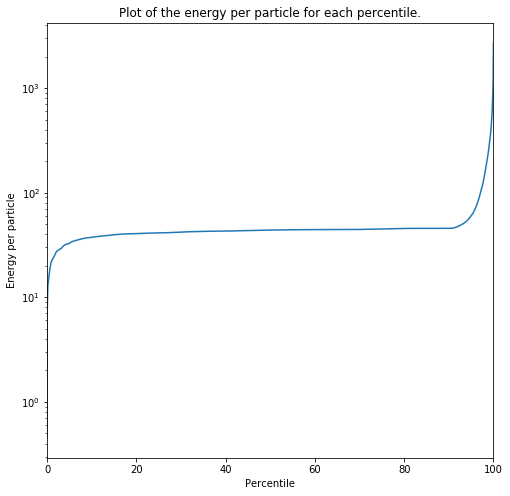

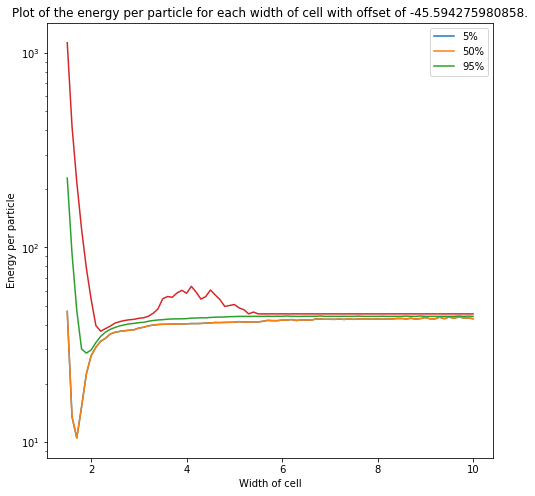

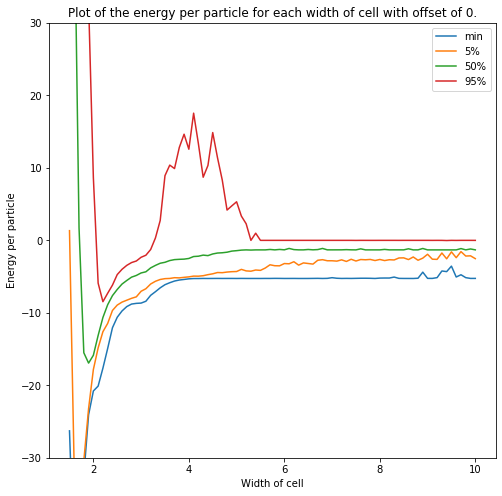

In [66]:

#"""
qLow = data['potentialEnergy'].quantile(0.01)
qHi  = data['potentialEnergy'].quantile(0.99)
dataFiltered = data.copy()
#dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()

#"""


#"""
tempData = dataFiltered.copy()
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

#"""
tempData = dataFiltered.copy()
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-30, 30)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


## Preparing data

In [67]:
#"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    #inputData.append(np.array(trainingData['eigenvalues'][i]))
    inputData.append(np.array(trainingData['relativeDistances'][i]))
    targetData.append(trainingData['potentialEnergy'][i])
    #targetData.append(sum(trainingData['eigenvalues'][i]))
    #targetData.append([sum(trainingData['relativeDistances'][i])])

trainingInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results training input:')
[print(trainingInput['input'][i], trainingInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(trainingInput['input']))
print(type(trainingInput['input']))
print(type(trainingInput['input'][0]))
print(np.shape(trainingInput['target']))
print(type(trainingInput['target']))

inputData = []
targetData = []
for i in validationData.index:
    #inputData.append(np.array(validationData['eigenvalues'][i]))
    inputData.append(np.array(validationData['relativeDistances'][i]))
    targetData.append(validationData['potentialEnergy'][i])
    #targetData.append([sum(validationData['eigenvalues'][i])])
    #targetData.append([sum(validationData['relativeDistances'][i])])

validationInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results validation input:')
[print(validationInput['input'][i], validationInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(validationInput['input']))
print(type(validationInput['input']))
print(type(validationInput['input'][0]))
print(np.shape(validationInput['target']))
print(type(validationInput['target']))

validationPlots = [random.choice(validationData.index) for i in range(0, 11)]

#"""
print()

Results training input:
[ 4.4         0.46905527  1.31971741  3.35882889  7.93414015  8.289279
 10.5571311   0.32124475  1.51607755  6.155762   22.34857319 23.86575268
 34.30195494] -0.9511160753000001 

[2.         0.7068329  0.92607496 0.97469521 1.12403978 1.22730234
 3.54292107 0.59425813 0.89118776 0.96228396 1.19171532 1.35965067
 6.6687159 ] -16.7256898306 

[ 3.9         0.49101515  0.98059808  1.68721214 14.42666096 19.76929719
 21.48890554  0.34406646  0.97103875  2.19156592 54.79598506 87.89958918
 99.61424445] -2.6551028945 

(51960, 13)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(51960,)
<class 'numpy.ndarray'>
Results validation input:
[ 2.7         0.13553743  1.33605158  2.27970221  2.37086254  5.3783421
  6.51344192  0.04989866  1.54431126  3.44205005  3.6505606  12.47304917
 16.62324546] -4.3657142404 

[ 2.7         0.45768364  1.23697805  1.56247104  5.98182477  6.60161868
  9.10125528  0.30963361  1.37576099  1.9530707  14.63020899 16.96194506
 27.45692793] -4

## Preparing test data

No handles with labels found to put in legend.


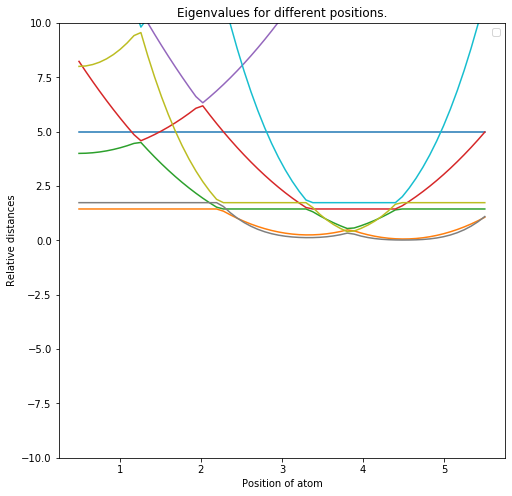

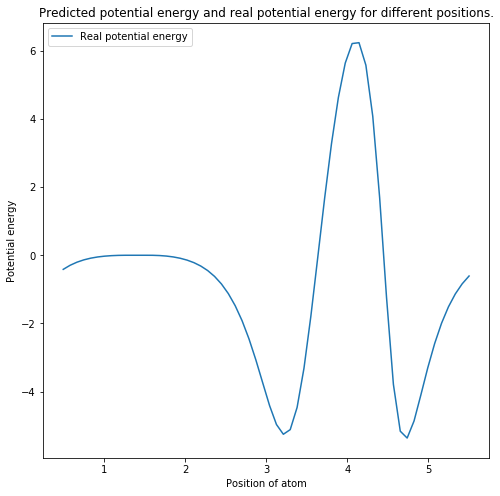

In [68]:
#"""
widthOfCell = 5.0
numberOfSurroundingCells = 3
R0 = 20
x = np.linspace(0.1, 1.1, 60)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.1, 0.1]), np.array([0.55, 0.9]), np.array([0.6, 0.665]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

fig, ax1 = plt.subplots(figsize=(8, 8))
#ax1.plot(list(x), [testData['Eigenvalues'][i] for i in range(0, len(testData['Eigenvalues']))])
ax1.plot(list(x), [testData['relativeDistances'][i] for i in range(0, len(testData['relativeDistances']))])
ax1.legend()
ax1.set_ylim(-10, 10)
ax1.set_xlabel('Position of atom')
#ax1.set_ylabel('Eigenvalues')
ax1.set_ylabel('Relative distances')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()

y = []
for i in range(len(x)):
    y.append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y, label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()
#"""
print()

# Machine learning

In [69]:
def RSMPE(target,value):
    return ((keras.backend.mean(((value-target)/target)**2))**0.5)*100

def MAE(target,value):
    return keras.backend.mean(abs(value-target))

models = []
prefixName = 0
saveFolder = 'testRun'
lossMetric = MAE#keras.losses.MeanAbsoluteError()#keras.losses.MeanSquaredError()
#trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
#fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))


## Model 0: Linear network

In [74]:
name = 'LinearNetwork'
settingsLineaerNet = [['Dense', 1, 'linear', False]]
learningRate = 1*10**-4
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE)
#model.layers[0].set_weights([np.array([[1] for i in range(inputSize)])])
#model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(inputSize)])])


model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
print(model.evaluate(trainingInput['input'], trainingInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
12990/12990 [==============================] - 0s 24us/step
107.0231182095452
51960/51960 [==============================] - 1s 24us/step
108.13311053621851
Layer 0:  [array([[ 0.6410731 ],
       [ 0.30550408],
       [-0.6063032 ],
       [-0.19502407],
       [ 0.11475289],
       [-0.12238443],
       [ 0.5480453 ],
       [ 0.5127939 ],
       [-0.06580561],
       [ 0.20466524],
       [ 0.38748896],
       [ 0.5012711 ],
       [ 0.55831504]], dtype=float32)]


Train on 36372 samples, validate on 15588 samples
Epoch 1/100
36372/36372 [==============================] - 2s 57us/step - loss: 95.0986 - val_loss: 81.7257
Epoch 2/100
36372/36372 [==============================] - 2s 56us/step - loss: 69.2010 - val_loss: 56.3547
Epoch 3/100
36372/36372 [==============================] - 2s 54us/step - loss: 43.6442 - val_loss: 31.5775
Epoch 4/100
36372/36372 [==============================] - 2s 58us/step - loss: 22.7866 - val_loss: 18.0302
Epoch 5/100
36372/36372 [==============================] - 2s 53us/step - loss: 16.2572 - val_loss: 15.6492
Epoch 6/100
36372/36372 [==============================] - 2s 54us/step - loss: 14.6170 - val_loss: 14.3927
Epoch 7/100
36372/36372 [==============================] - 2s 55us/step - loss: 13.5094 - val_loss: 13.5531
Epoch 8/100
36372/36372 [==============================] - 2s 54us/step - loss: 12.8125 - val_loss: 13.0476
Epoch 9/100
36372/36372 [==============================] - 2s 54us/step - loss: 12.392

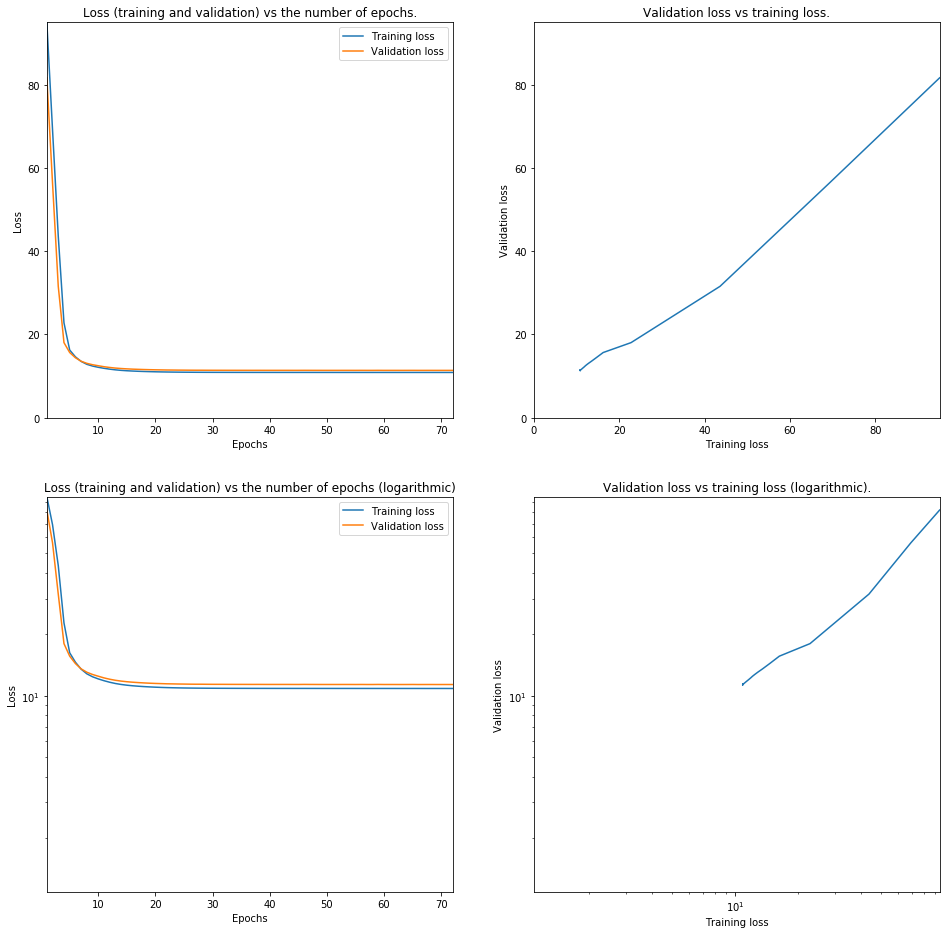

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
10.821300387345799
Layer 0:  [array([[-7.1413255e-01],
       [-2.5198558e-01],
       [ 6.3338992e-03],
       [-8.1148604e-03],
       [ 2.6593946e-02],
       [-4.6276733e-02],
       [ 2.5493014e-01],
       [ 8.6375423e-02],
       [ 4.9021968e-04],
       [ 1.6720345e-03],
       [-5.4794122e-03],
       [ 5.6939893e-03],
       [-1.9837679e-02]], dtype=float32)]


In [75]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=100, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

10.821300387345799


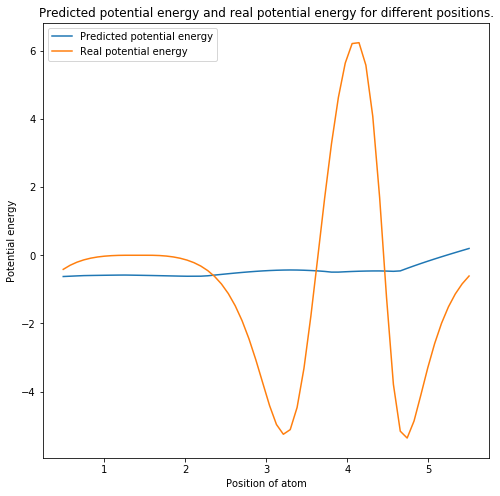

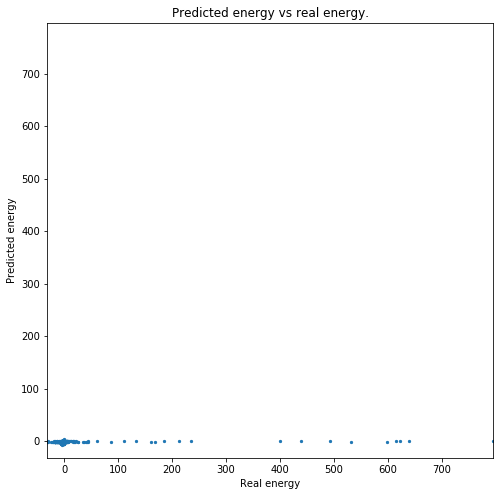

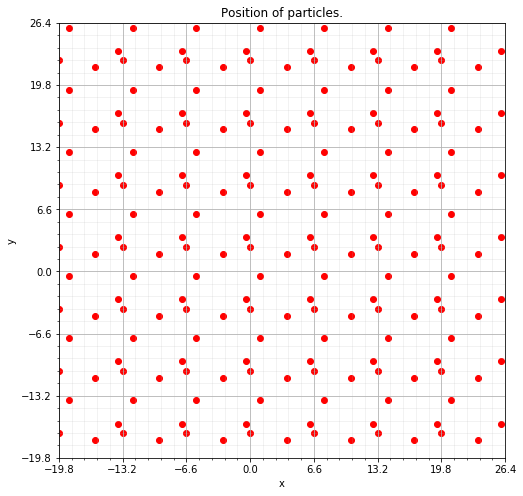

For index 19871 Predicted 0.012218952 was 0.0


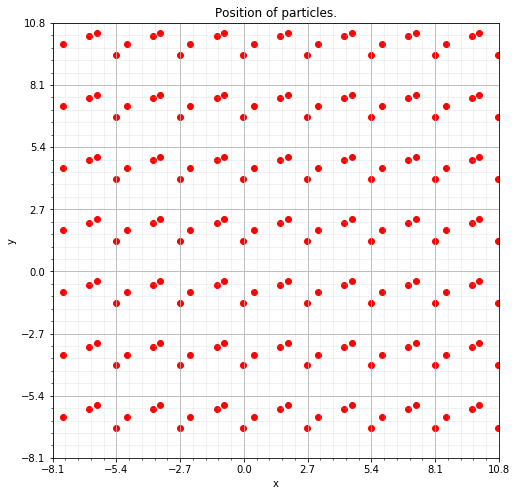

For index 47360 Predicted -0.9100912 was -5.4906443142


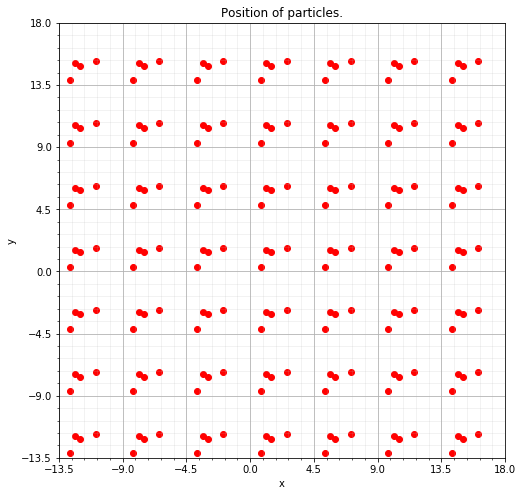

For index 30014 Predicted -2.1925693 was -2.7523620391


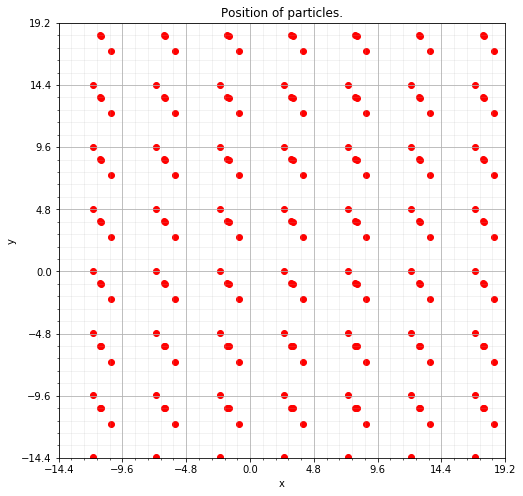

For index 15684 Predicted -1.0262189 was 2.8508411184


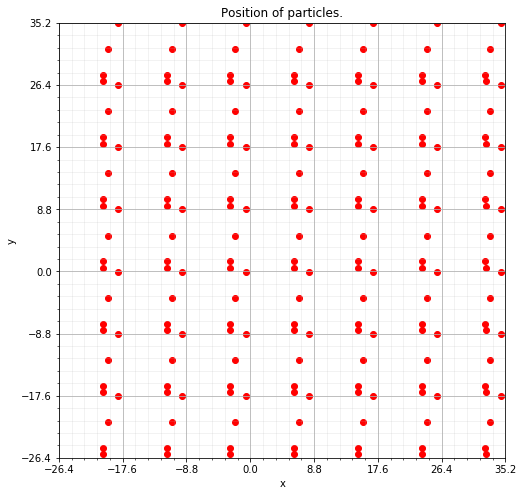

For index 46811 Predicted -0.23178959 was -0.0029364077


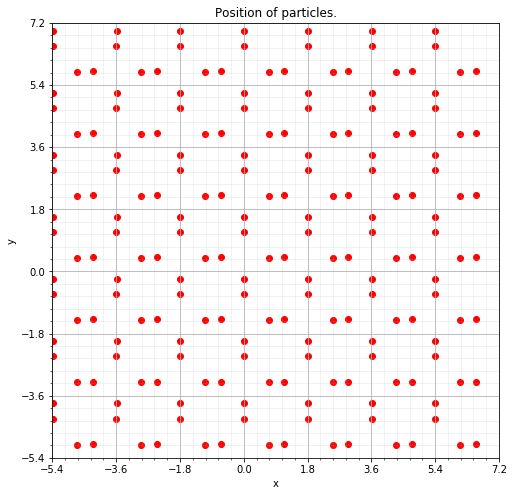

For index 18339 Predicted -0.7795925 was -25.0152495633


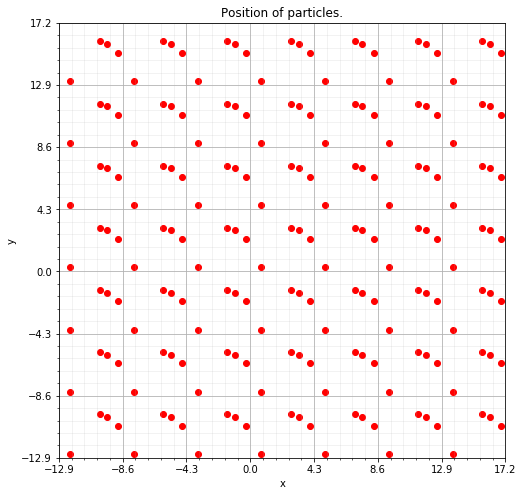

For index 59735 Predicted -0.7885345 was -1.3155010496


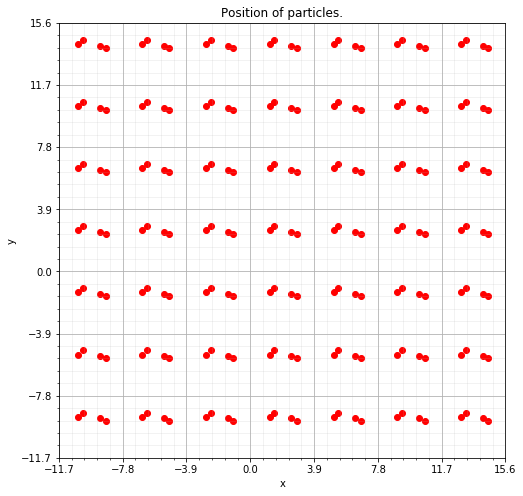

For index 35315 Predicted -2.2397923 was -3.9672140992


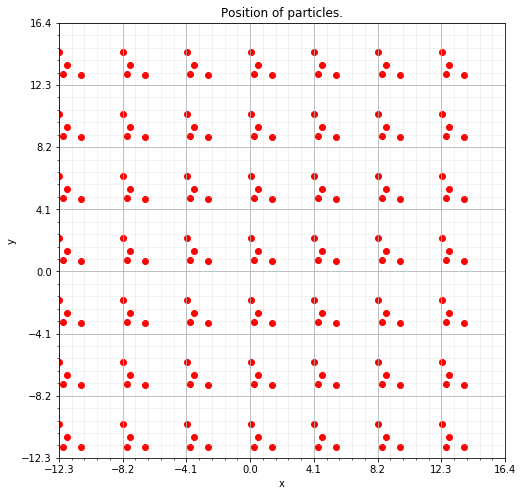

For index 39413 Predicted -2.1699252 was -2.9240681371


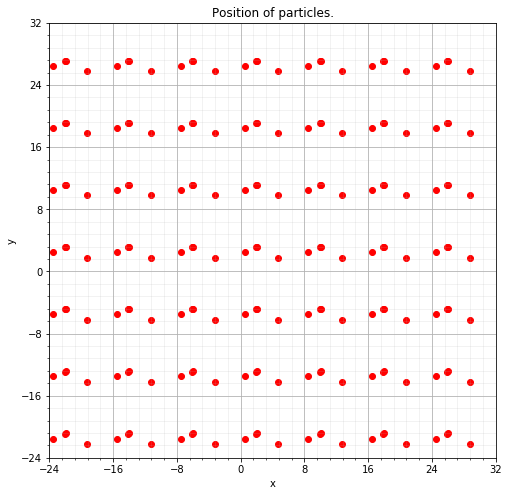

For index 40443 Predicted -2.754768 was -0.9665901616


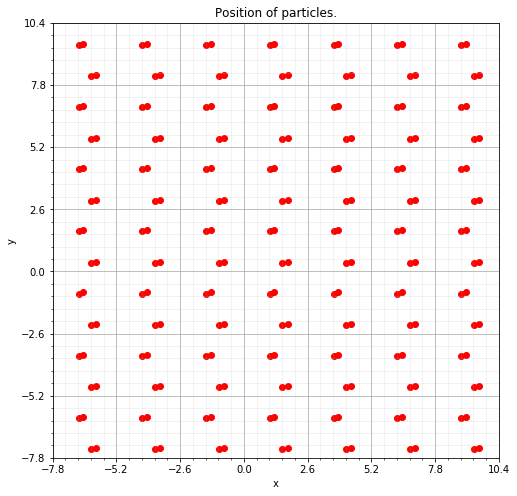

For index 49054 Predicted -1.4326237 was -8.9207659222


In [76]:
print(evaluation)

y = [[],[]]
for i in range(len(x)):
    #y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[0].append(model.predict([[testData['relativeDistances'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

## Model 1: 1 Dense layer

In [77]:
name = 'OneDenseLayer'
settingsLineaerNet = [['Dense', 128, 'softplus', False],['Dense', 1, 'linear', False]]
learningRate = 1*10**-5
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE)

model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 128       
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
12990/12990 [==============================] - 0s 25us/step
90.092017591798
Layer 0:  [array([[-0.33257994, -0.15533876,  0.4571632 , ...,  0.5463445 ,
         0.24940991, -0.5562545 ],
       [ 0.5937854 , -0.6196746 ,  0.4940617 , ..., -0.04112267,
         0.64307296,  0.33508003],
       [ 0.6463591 ,  0.30185306, -0.6427026 , ..., -0.12001848,
         0.29566616,  0.28582674],
       ...,
       [ 0.00629461,  0.49654996, -0.09140784, ...,  0.04542094,
         0.05116987,  0.29031438],
       [-0.3198

Train on 36372 samples, validate on 15588 samples
Epoch 1/500
36372/36372 [==============================] - 2s 61us/step - loss: 68.6805 - val_loss: 46.1842
Epoch 2/500
36372/36372 [==============================] - 2s 57us/step - loss: 27.3520 - val_loss: 17.0402
Epoch 3/500
36372/36372 [==============================] - 2s 60us/step - loss: 15.6355 - val_loss: 15.1611
Epoch 4/500
36372/36372 [==============================] - 2s 57us/step - loss: 14.1293 - val_loss: 13.9874
Epoch 5/500
36372/36372 [==============================] - 2s 58us/step - loss: 13.1349 - val_loss: 13.2407
Epoch 6/500
36372/36372 [==============================] - 2s 55us/step - loss: 12.4758 - val_loss: 12.6782
Epoch 7/500
36372/36372 [==============================] - 2s 57us/step - loss: 11.9691 - val_loss: 12.2319
Epoch 8/500
36372/36372 [==============================] - 2s 61us/step - loss: 11.5662 - val_loss: 11.8971
Epoch 9/500
36372/36372 [==============================] - 2s 57us/step - loss: 11.267

36372/36372 [==============================] - 2s 55us/step - loss: 9.8621 - val_loss: 10.3520
Epoch 77/500
36372/36372 [==============================] - 2s 55us/step - loss: 9.8600 - val_loss: 10.3443
Epoch 78/500
36372/36372 [==============================] - 2s 55us/step - loss: 9.8574 - val_loss: 10.3440
Epoch 79/500
36372/36372 [==============================] - 2s 55us/step - loss: 9.8554 - val_loss: 10.3396
Epoch 80/500
36372/36372 [==============================] - 2s 55us/step - loss: 9.8523 - val_loss: 10.3378
Epoch 81/500
36372/36372 [==============================] - 2s 55us/step - loss: 9.8501 - val_loss: 10.3444
Epoch 82/500
36372/36372 [==============================] - 2s 55us/step - loss: 9.8475 - val_loss: 10.3327
Epoch 83/500
36372/36372 [==============================] - 2s 55us/step - loss: 9.8449 - val_loss: 10.3324
Epoch 84/500
36372/36372 [==============================] - 2s 55us/step - loss: 9.8428 - val_loss: 10.3315
Epoch 85/500
36372/36372 [===============

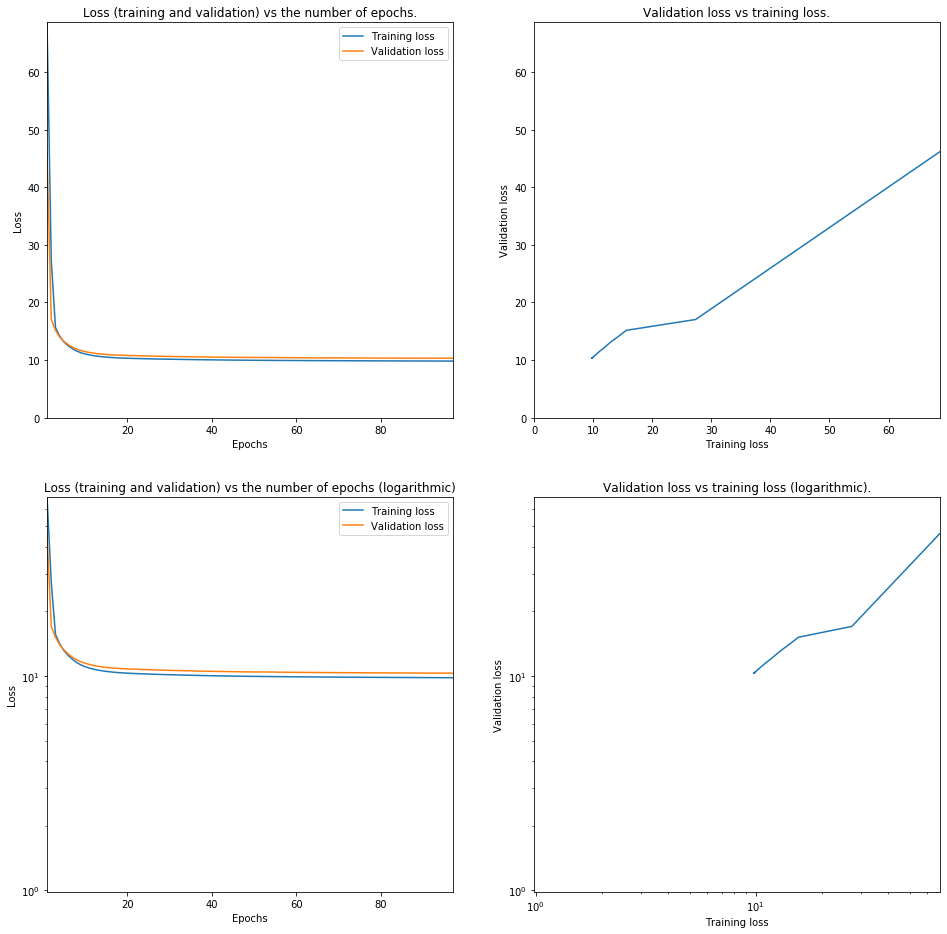

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 128       
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
9.798802956899742
Layer 0:  [array([[-0.41829875, -0.22593746,  0.32643574, ...,  0.46578538,
         0.2307107 , -0.54270226],
       [ 0.8073324 , -0.50427353,  0.6836491 , ...,  0.09780133,
         0.6748825 ,  0.36075613],
       [ 0.6018025 ,  0.23880313, -0.7408605 , ..., -0.15819001,
         0.23567064,  0.22249976],
       ...,
       [ 0.08869191,  0.43329406, -0.05062902, ...,  0.0879874 ,
         0.07920891,  0.31254625],
       [-0.21660274, -0.3367086 , -0.37523535, ..., -0.34550047,
        

In [78]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=500, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

9.798802956899742


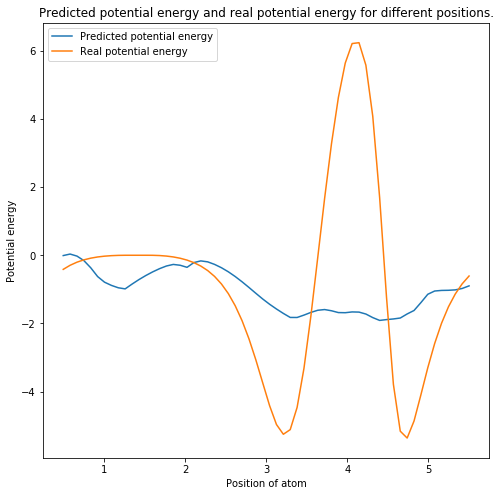

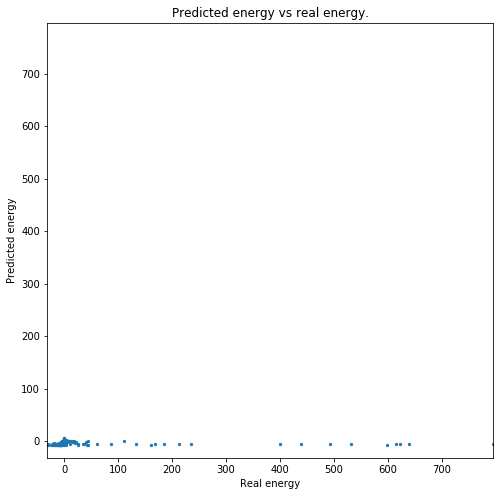

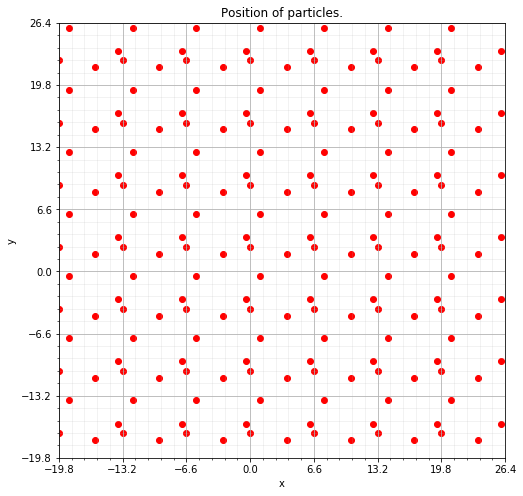

For index 19871 Predicted 0.49233055 was 0.0


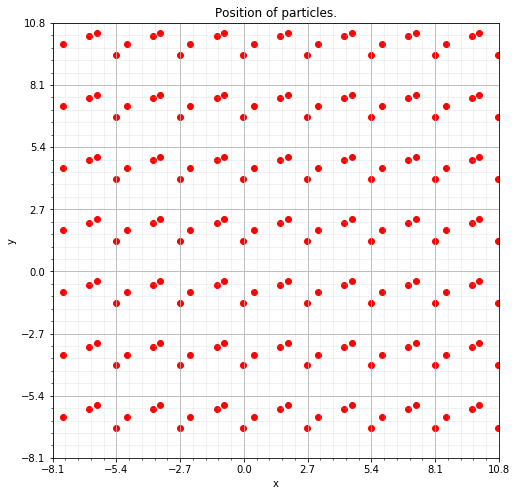

For index 47360 Predicted -3.3497689 was -5.4906443142


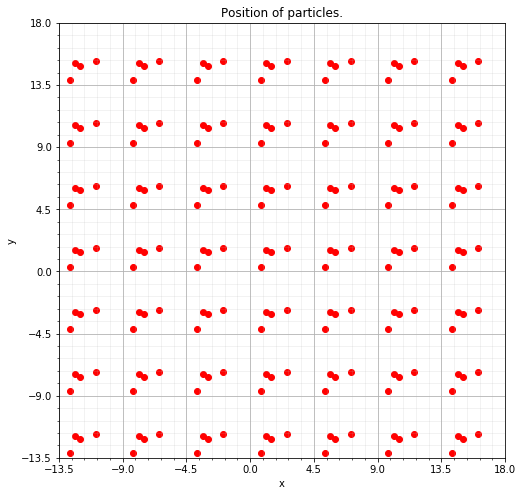

For index 30014 Predicted -2.6928897 was -2.7523620391


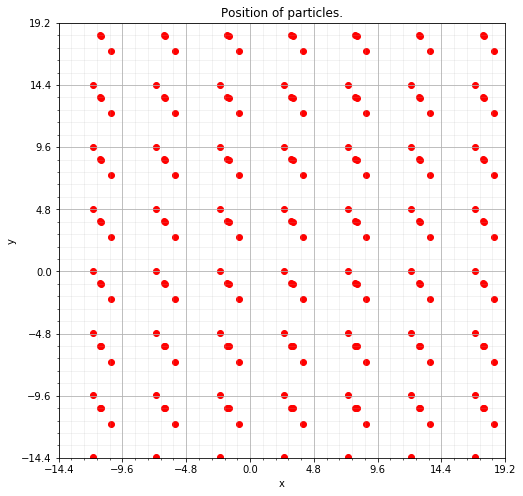

For index 15684 Predicted -1.4794348 was 2.8508411184


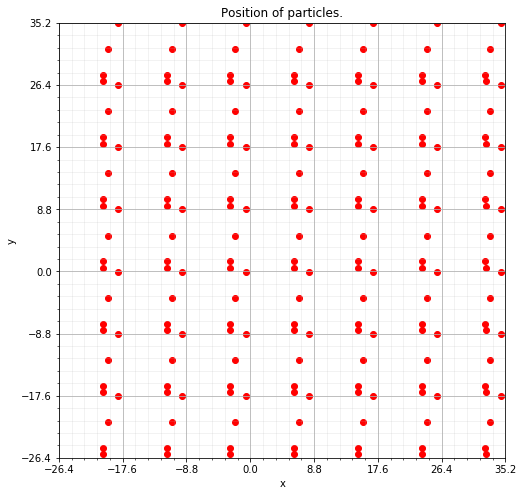

For index 46811 Predicted 0.4548111 was -0.0029364077


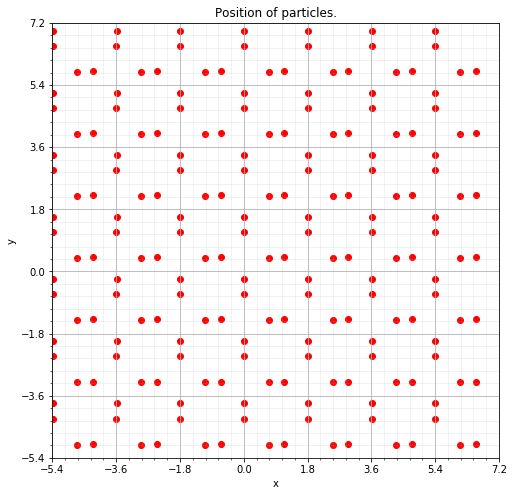

For index 18339 Predicted -5.8003364 was -25.0152495633


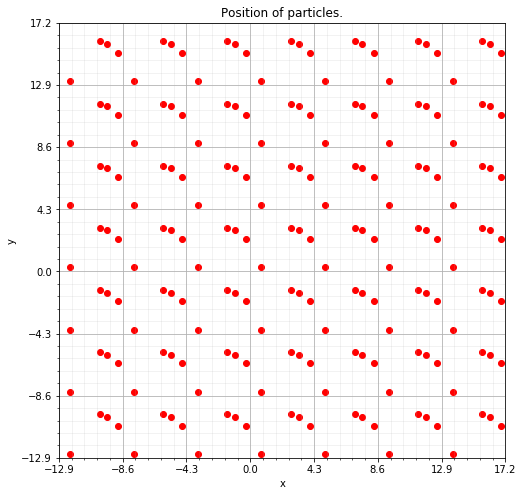

For index 59735 Predicted -1.2739456 was -1.3155010496


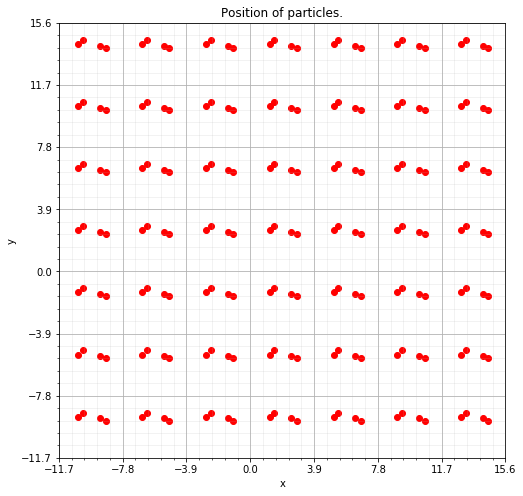

For index 35315 Predicted -4.1519737 was -3.9672140992


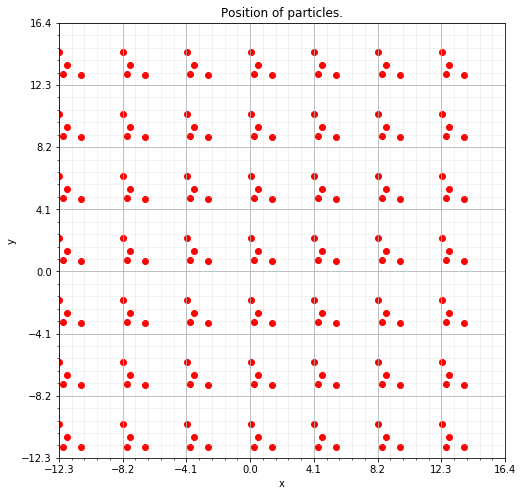

For index 39413 Predicted -3.0464032 was -2.9240681371


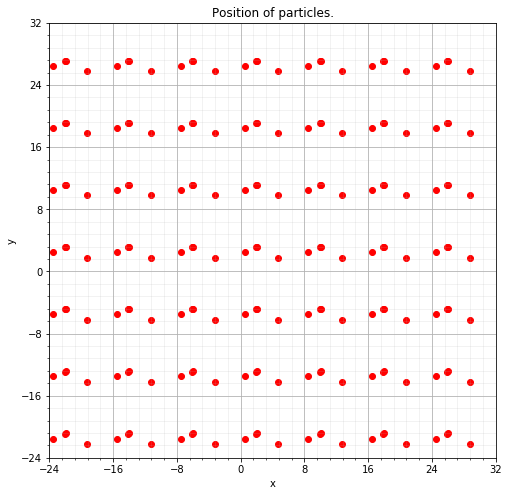

For index 40443 Predicted -0.6655009 was -0.9665901616


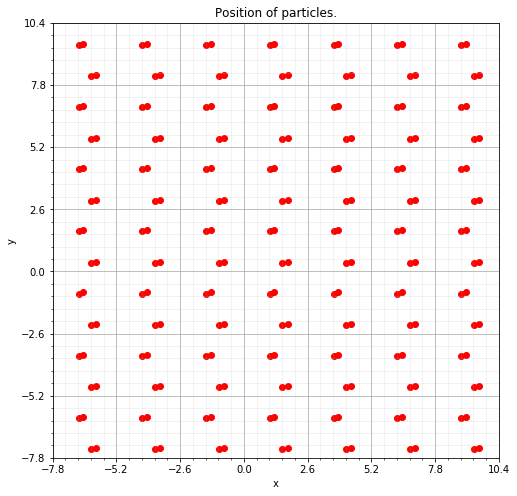

For index 49054 Predicted -6.7898808 was -8.9207659222


In [80]:
print(evaluation)

y = [[],[]]
for i in range(len(x)):
    #y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[0].append(model.predict([[testData['relativeDistances'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

## Model 2: 2 Dense layer

In [83]:
name = 'OneDenseLayer'
settingsLineaerNet = [['Dense', 128, 'softplus', False], ['Dense', 128, 'softplus', False],['Dense', 1, 'linear', False]]
learningRate = 1*10**-5
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE)

model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               1664      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16384     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 128       
Total params: 18,176
Trainable params: 18,176
Non-trainable params: 0
_________________________________________________________________
12990/12990 [==============================] - 1s 58us/step
18.40330849721672
Layer 0:  [array([[ 0.5173801 ,  0.2785961 ,  0.07350457, ...,  0.61512625,
         0.07945663, -0.20535523],
       [-0.35049048,  0.35851324, -0.468604  , ..., -0.5888159 ,
        -0.12713724,  0.04227412],
       [ 0.41435838,  0.24860978, -0.6116023 , ..., -0.34530684,
         0.10640091,  0.5

Train on 36372 samples, validate on 15588 samples
Epoch 1/200
36372/36372 [==============================] - 5s 140us/step - loss: 12.0001 - val_loss: 11.2794
Epoch 2/200
36372/36372 [==============================] - 5s 139us/step - loss: 10.6405 - val_loss: 11.0922
Epoch 3/200
36372/36372 [==============================] - 5s 140us/step - loss: 10.4772 - val_loss: 10.8934
Epoch 4/200
36372/36372 [==============================] - 5s 139us/step - loss: 10.3716 - val_loss: 10.8048
Epoch 5/200
36372/36372 [==============================] - 5s 141us/step - loss: 10.2744 - val_loss: 10.7247
Epoch 6/200
36372/36372 [==============================] - 5s 130us/step - loss: 10.1837 - val_loss: 10.6191
Epoch 7/200
36372/36372 [==============================] - 5s 147us/step - loss: 10.1154 - val_loss: 10.5605
Epoch 8/200
36372/36372 [==============================] - 8s 225us/step - loss: 10.0743 - val_loss: 10.5450
Epoch 9/200
36372/36372 [==============================] - 6s 173us/step - los

36372/36372 [==============================] - 12s 343us/step - loss: 9.6774 - val_loss: 10.1916
Epoch 76/200
36372/36372 [==============================] - 10s 280us/step - loss: 9.6763 - val_loss: 10.1560
Epoch 77/200
36372/36372 [==============================] - 4s 120us/step - loss: 9.6731 - val_loss: 10.1594
Epoch 78/200
36372/36372 [==============================] - 4s 119us/step - loss: 9.6730 - val_loss: 10.1666
Epoch 79/200
36372/36372 [==============================] - 4s 118us/step - loss: 9.6663 - val_loss: 10.1534
Epoch 80/200
36372/36372 [==============================] - 5s 150us/step - loss: 9.6644 - val_loss: 10.1605
Epoch 81/200
36372/36372 [==============================] - 5s 128us/step - loss: 9.6648 - val_loss: 10.1454
Epoch 82/200
36372/36372 [==============================] - 5s 135us/step - loss: 9.6625 - val_loss: 10.1448
Epoch 83/200
36372/36372 [==============================] - 4s 119us/step - loss: 9.6592 - val_loss: 10.1415
Epoch 84/200
36372/36372 [====

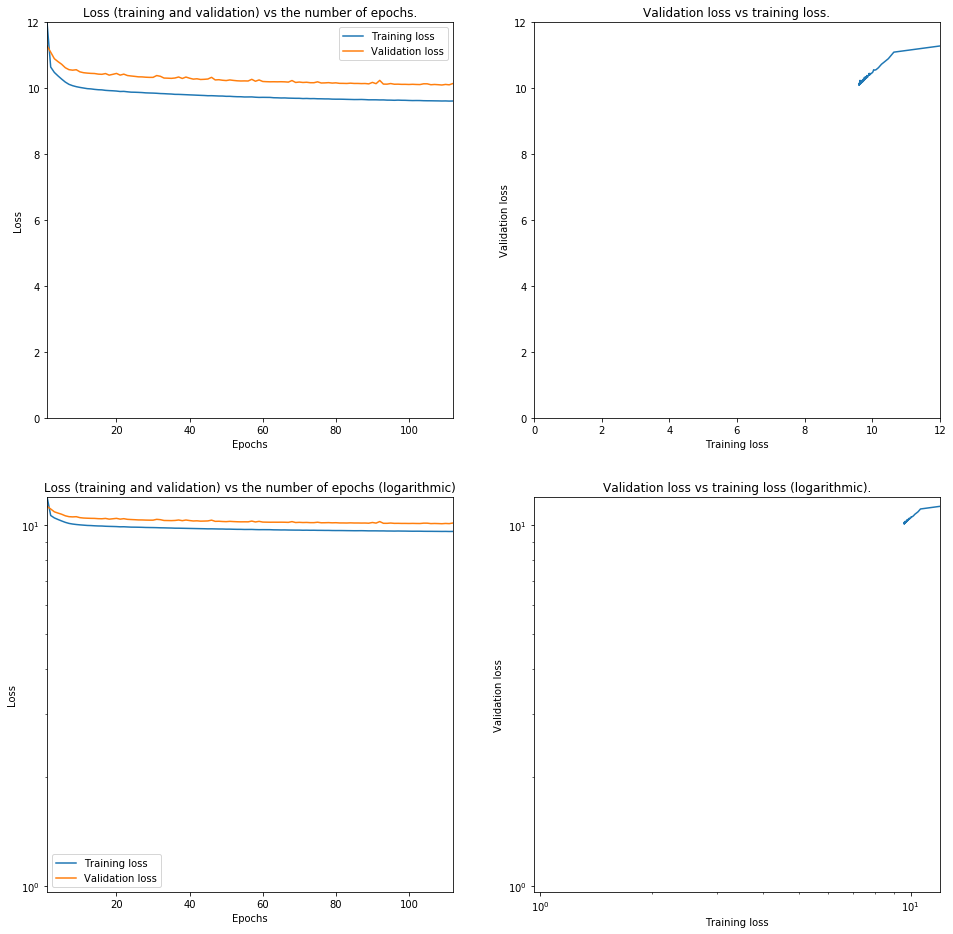

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               1664      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16384     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 128       
Total params: 18,176
Trainable params: 18,176
Non-trainable params: 0
_________________________________________________________________
9.639523275399593
Layer 0:  [array([[ 0.5414926 ,  0.30566385,  0.06073495, ...,  0.61012876,
         0.12463835, -0.22621273],
       [-0.41292357,  0.31787485, -0.47554886, ..., -0.55443805,
        -0.24517147,  0.09698457],
       [ 0.4028537 ,  0.24023727, -0.60271174, ..., -0.33050936,
         0.06439836,  0.6088543 ],
       ...,
       [-0.01583566,  0.07953756,  0.6

In [84]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=200, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

9.639523275399593


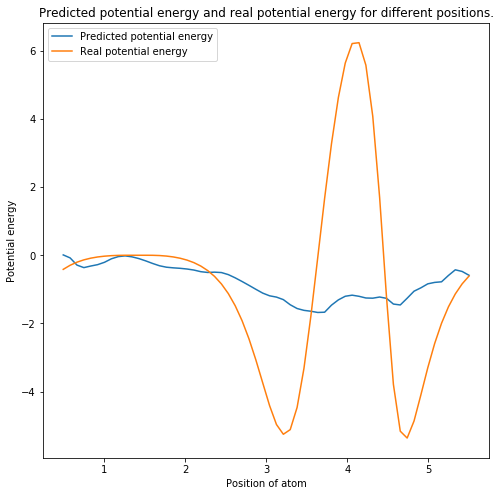

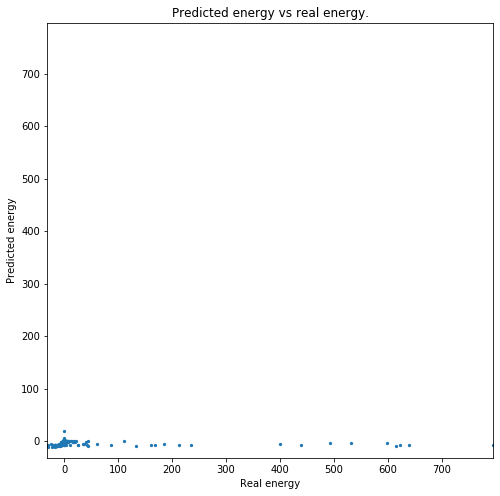

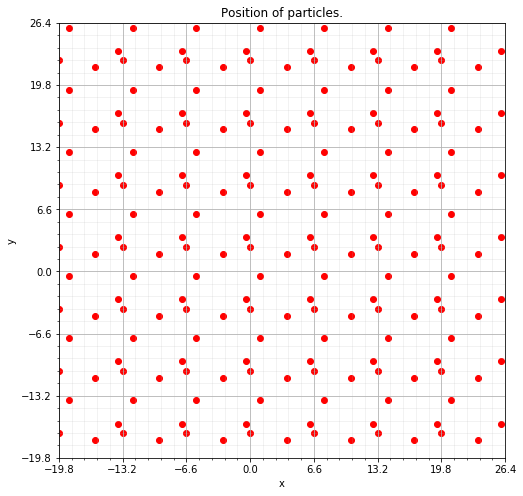

For index 19871 Predicted -0.49100724 was 0.0


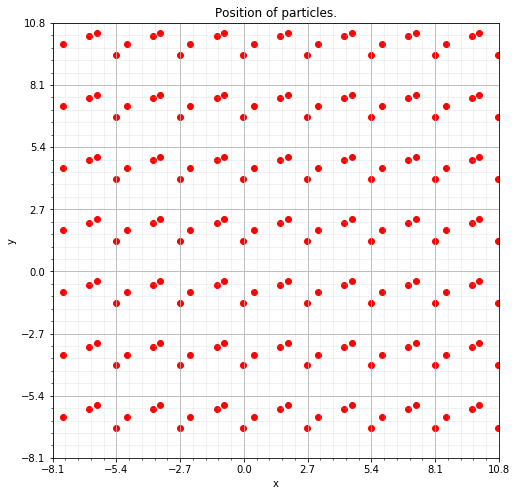

For index 47360 Predicted -4.2031116 was -5.4906443142


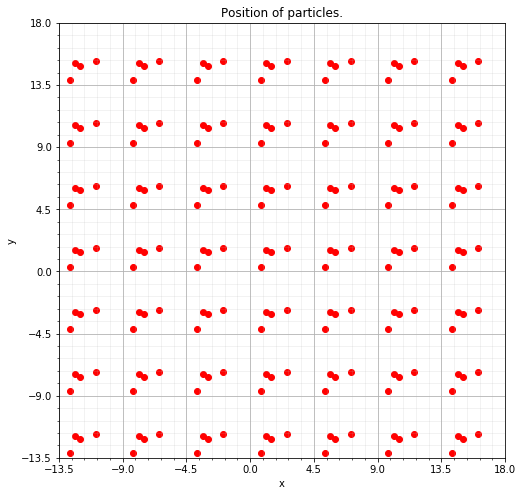

For index 30014 Predicted -2.7302992 was -2.7523620391


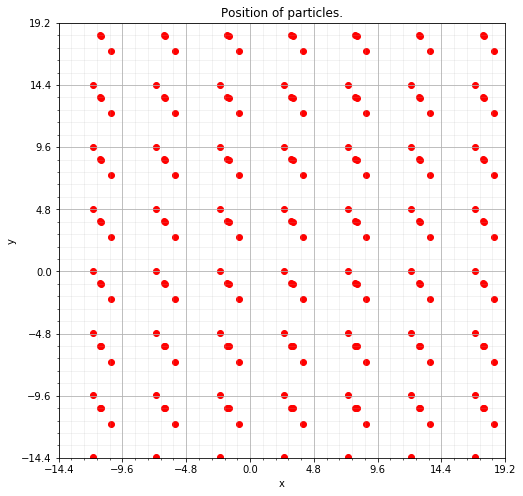

For index 15684 Predicted -1.3185645 was 2.8508411184


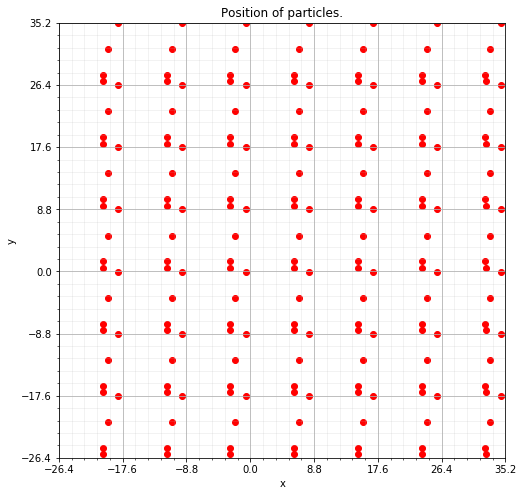

For index 46811 Predicted 1.6815434 was -0.0029364077


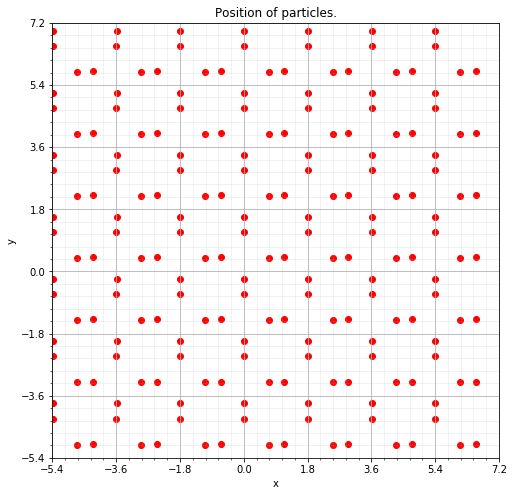

For index 18339 Predicted -7.9597683 was -25.0152495633


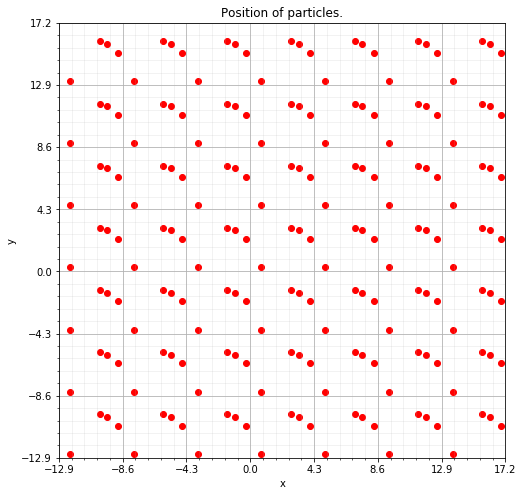

For index 59735 Predicted -1.1823323 was -1.3155010496


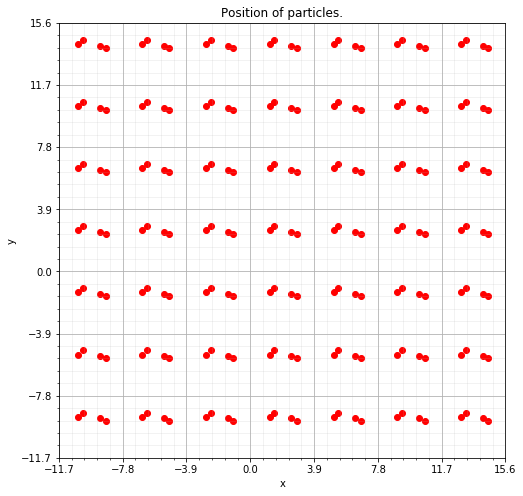

For index 35315 Predicted -3.7960691 was -3.9672140992


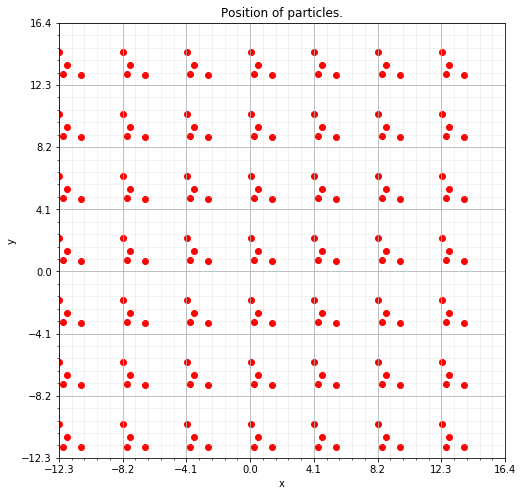

For index 39413 Predicted -3.169821 was -2.9240681371


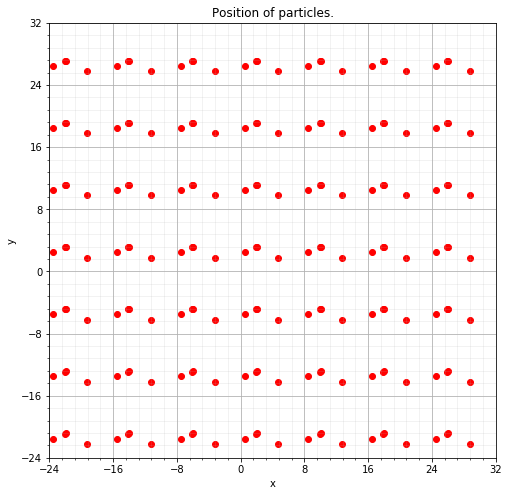

For index 40443 Predicted -0.69124675 was -0.9665901616


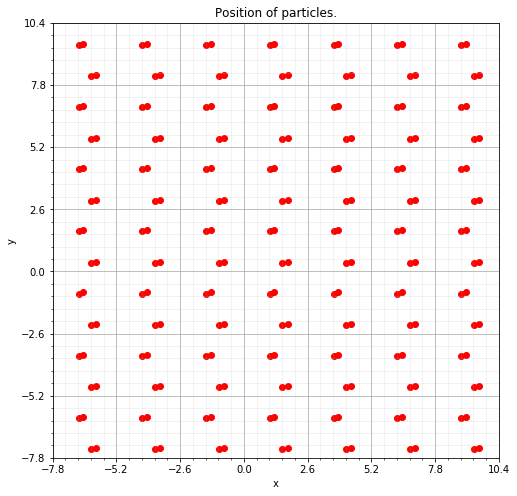

For index 49054 Predicted -8.448357 was -8.9207659222


In [85]:
print(evaluation)

y = [[],[]]
for i in range(len(x)):
    #y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[0].append(model.predict([[testData['relativeDistances'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)

# Finishing

In [ ]:

#print(evaluation)

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

"""
makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)
"""
#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


In [ ]:
for i in range(len(models)):
    model = models[i]['model']
    print(models[i]['name'])
    print(model.summary())
    print(models[i]['evaluation'])
    model.save(saveFolder + '/' + models[i]['name'] + str(models[i]['evaluation']) + '.h5')
    print('\n \n')

#model = models[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')

# TEMP

In [ ]:
print(np.shape(trainingInput['input']))
print(np.shape(trainingInput['target']))

In [ ]:
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
#print(dataset)
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

print(np.shape(X))
print(np.shape(y))
print(X)
print(y)

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=150, batch_size=10)